In [23]:
from pathlib import Path
import pickle
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../")

from src.readers.geom_reader import load_geodata
from src.readers.hydro_series import load_metrics_from_directory
from src.timeseries_stats.metrics import evaluate_model
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

log = setup_logger("chapter_two", log_file="../logs/chapter_two.log")
# Base paths for optimization results
BASE_PATHS = {
    "GR4J": Path("../data/optimization/gr4j_simple"),
    "HBV": Path("../data/optimization/hbv_simple"),
    "RFR": Path("../data/optimization/rfr_simple"),
}
# Load watershed geometries and gauge locations
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
# Load cluster assignments (from Chapter 1)
gauge_mapping = pd.read_csv(
    "../res/chapter_one/gauge_hybrid_mapping.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

print(f"Loaded {len(gauges)} gauges with hybrid classification")

Loaded 996 gauges with hybrid classification


In [24]:
# ============================================================================
# LOAD MODEL RESULTS FROM ALL SOURCES
# ============================================================================

# Load data for all conceptual/ML models
model_data = {}
for model_name, base_path in BASE_PATHS.items():
    log.info(f"Loading {model_name} results from {base_path}")
    model_data[model_name] = load_metrics_from_directory(base_path)

# Create separate dataframes for each model-dataset combination
dataset_dfs = {}
source_names = ["e5l", "gpcp", "e5", "mswep"]

for model_name, model_dict in model_data.items():
    sample_gauge = next(iter(model_dict))
    datasets = list(model_dict[sample_gauge].keys())

    for dataset_name in datasets:
        rows = []
        for gauge_id, gauge_data in model_dict.items():
            if dataset_name in gauge_data:
                metrics = gauge_data[dataset_name]
                row = {"gauge_id": gauge_id}
                row.update(metrics)
                rows.append(row)

        df_name = f"{model_name.lower()}_{dataset_name}"
        df = pd.DataFrame(rows).set_index("gauge_id")
        df = df.reindex(common_index)
        dataset_dfs[df_name] = df

log.info(f"Created {len(dataset_dfs)} model/source dataframes")

# Create individual variables for conceptual/ML models
gr4j_e5l, gr4j_gpcp, gr4j_e5, gr4j_mswep = (
    dataset_dfs["gr4j_e5l"],
    dataset_dfs["gr4j_gpcp"],
    dataset_dfs["gr4j_e5"],
    dataset_dfs["gr4j_mswep"],
)

hbv_e5l, hbv_gpcp, hbv_e5, hbv_mswep = (
    dataset_dfs["hbv_e5l"],
    dataset_dfs["hbv_gpcp"],
    dataset_dfs["hbv_e5"],
    dataset_dfs["hbv_mswep"],
)

rfr_e5l, rfr_gpcp, rfr_e5, rfr_mswep = (
    dataset_dfs["rfr_e5l"],
    dataset_dfs["rfr_gpcp"],
    dataset_dfs["rfr_e5"],
    dataset_dfs["rfr_mswep"],
)

# ============================================================================
# LOAD LSTM RESULTS FROM PICKLE FILES
# ============================================================================

lstm_pathes = {
    "gpcp": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p",
    "e5": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p",
    "e5l": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p",
    "mswep": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p",
    "ealstm": "../data/lstm_configs/model_runs/ealstm_q_mm_day_mswep_no_static_0205_144958/test/model_epoch038/test_results.p",
}

lstm_dataset_dfs = {}

for dataset_name, pickle_path in lstm_pathes.items():
    log.info(f"Processing LSTM {dataset_name}")

    with open(pickle_path, "rb") as f:
        lstm_data = pickle.load(f)

    rows = []
    for gauge_id, gauge_results in lstm_data.items():
        if gauge_id in common_index:
            try:
                xr_data = gauge_results["1D"]["xr"]
                obs = np.asarray(xr_data["q_mm_day_obs"], dtype=float).flatten()
                sim = np.asarray(xr_data["q_mm_day_sim"], dtype=float).flatten()

                metrics = evaluate_model(observed=obs, simulated=sim)
                metrics["gauge_id"] = gauge_id
                rows.append(metrics)
            except Exception as e:
                log.warning(
                    f"Error processing gauge {gauge_id} for LSTM {dataset_name}: {e}"
                )
                continue

    df_name = f"lstm_{dataset_name}"
    df = pd.DataFrame(rows).set_index("gauge_id")
    df = df.reindex(common_index)
    lstm_dataset_dfs[df_name] = df

log.info(f"Created {len(lstm_dataset_dfs)} LSTM dataframes")

# Create individual LSTM variables
lstm_e5l, lstm_gpcp, lstm_e5, lstm_mswep, ealstm_mswep = (
    lstm_dataset_dfs["lstm_e5l"],
    lstm_dataset_dfs["lstm_gpcp"],
    lstm_dataset_dfs["lstm_e5"],
    lstm_dataset_dfs["lstm_mswep"],
    lstm_dataset_dfs["lstm_ealstm"],
)

# ============================================================================
# DATA LOADING SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("DATA LOADING SUMMARY")
print("=" * 80)
print(f"\nTotal gauges: {len(common_index)}")
print(f"Conceptual/ML models: {len(dataset_dfs)} dataframes")
print(f"LSTM models: {len(lstm_dataset_dfs)} dataframes")
print("\nSample metrics per model:")
for model_prefix in ["gr4j", "hbv", "rfr", "lstm"]:
    df_key = f"{model_prefix}_e5l"
    if df_key in dataset_dfs:
        sample_df = dataset_dfs[df_key]
    elif df_key in lstm_dataset_dfs:
        sample_df = lstm_dataset_dfs[df_key]
    else:
        continue
    valid_count = sample_df["NSE"].notna().sum()
    median_nse = sample_df["NSE"].median()
    print(
        f"  {model_prefix.upper():6s}: {valid_count:3d} valid gauges, Median NSE={median_nse:.3f}"
    )
print("\n✓ Data loading complete")


2025-12-10 18:51:36 | INFO     | PhDLogger | chapter_two | ℹ️  Loading GR4J results from ../data/optimization/gr4j_simple
2025-12-10 18:51:39 | INFO     | PhDLogger | chapter_two | ℹ️  Loading HBV results from ../data/optimization/hbv_simple
2025-12-10 18:51:39 | INFO     | PhDLogger | chapter_two | ℹ️  Loading HBV results from ../data/optimization/hbv_simple
2025-12-10 18:51:44 | INFO     | PhDLogger | chapter_two | ℹ️  Loading RFR results from ../data/optimization/rfr_simple
2025-12-10 18:51:44 | INFO     | PhDLogger | chapter_two | ℹ️  Loading RFR results from ../data/optimization/rfr_simple
2025-12-10 18:51:47 | INFO     | PhDLogger | chapter_two | ℹ️  Created 12 model/source dataframes
2025-12-10 18:51:47 | INFO     | PhDLogger | chapter_two | ℹ️  Processing LSTM gpcp
2025-12-10 18:51:47 | INFO     | PhDLogger | chapter_two | ℹ️  Created 12 model/source dataframes
2025-12-10 18:51:47 | INFO     | PhDLogger | chapter_two | ℹ️  Processing LSTM gpcp
2025-12-10 18:51:48 | INFO     | P


DATA LOADING SUMMARY

Total gauges: 996
Conceptual/ML models: 12 dataframes
LSTM models: 5 dataframes

Sample metrics per model:
  GR4J  : 994 valid gauges, Median NSE=0.519
  HBV   : 996 valid gauges, Median NSE=0.563
  RFR   : 996 valid gauges, Median NSE=0.557
  LSTM  : 996 valid gauges, Median NSE=0.621

✓ Data loading complete


In [26]:
def get_quality_category(value: float, metric_type: str) -> str:
    """Map metric score to quality category using standard thresholds.

    Args:
        value: Metric value
        metric_type: One of 'NSE', 'R2', or 'PBIAS'

    Returns:
        Quality category: 'Отл.', 'Хор.', 'Удов.', or 'Плох.'

    Example:
        >>> get_quality_category(0.85, "NSE")
        'Отл.'
        >>> get_quality_category(12.0, "PBIAS")
        'Хор.'
    """
    if pd.isna(value):
        return "Плох."

    if metric_type == "R2":
        if value > 0.85:
            return "Отл."
        elif value > 0.70:
            return "Хор."
        elif value > 0.50:
            return "Удов."
        else:
            return "Плох."

    elif metric_type == "NSE":
        if value > 0.80:
            return "Отл."
        elif value > 0.70:
            return "Хор."
        elif value > 0.50:
            return "Удов."
        else:
            return "Плох."

    elif metric_type == "PBIAS":
        abs_value = abs(value)
        if abs_value <= 10:
            return "Отл."
        elif abs_value <= 15:
            return "Хор."
        elif abs_value <= 45:
            return "Удов."
        else:
            return "Плох."

    else:
        raise ValueError(
            f"Unknown metric_type: {metric_type}. Must be 'R2', 'NSE', or 'PBIAS'"
        )


def calculate_composite_score(nse: float, r2: float, pbias: float) -> tuple[float, str]:
    """Calculate composite quality score from NSE, R2, and PBIAS.

    This function implements a multi-criteria evaluation:
    1. Classify each metric individually (Poor/Satisfactory/Good/Great)
    2. Encode to numeric scale (1/2/3/4)
    3. Average the three scores
    4. Decode back to categorical grade

    Args:
        nse: Nash-Sutcliffe Efficiency
        r2: Coefficient of Determination
        pbias: Percent Bias

    Returns:
        Tuple of (numeric_score, categorical_grade) where:
        - numeric_score: 1.0-4.0 (higher is better)
        - categorical_grade: 'Плох.', 'Удов.', 'Хор.', or 'Отл.'

    Example:
        >>> calculate_composite_score(0.85, 0.80, 12.0)
        (3.33, 'Хор.')
    """
    # Handle missing values
    if pd.isna(nse) or pd.isna(r2) or pd.isna(pbias):
        return 0.0, "Плох."

    # Step 1: Classify individual metrics
    nse_category = get_quality_category(nse, "NSE")
    r2_category = get_quality_category(r2, "R2")
    pbias_category = get_quality_category(pbias, "PBIAS")

    # Step 2: Encode to numeric scores
    category_to_score = {"Плох.": 1, "Удов.": 2, "Хор.": 3, "Отл.": 4}

    nse_score = category_to_score[nse_category]
    r2_score = category_to_score[r2_category]
    pbias_score = category_to_score[pbias_category]

    # Step 3: Aggregate scores (equal weighting)
    composite_numeric = (nse_score + r2_score + pbias_score) / 3.0

    # Step 4: Decode to categorical label
    if composite_numeric < 1.5:
        composite_category = "Плох."
    elif composite_numeric < 2.5:
        composite_category = "Удов."
    elif composite_numeric < 3.5:
        composite_category = "Хор."
    else:
        composite_category = "Отл."

    return composite_numeric, composite_category


# Display helper function documentation
print("\n" + "=" * 80)
print("HELPER FUNCTIONS DEFINED")
print("=" * 80)
print("  - get_quality_category(value, metric_type)")
print("  - calculate_composite_score(nse, r2, pbias)")
print("\nThresholds:")
print("  R²:    Отл. (>0.85) | Хор. (0.70-0.85) | Удов. (0.50-0.70) | Плох. (≤0.50)")
print("  NSE:   Отл. (>0.80) | Хор. (0.70-0.80) | Удов. (0.50-0.70) | Плох. (≤0.50)")
print("  PBIAS: Отл. (≤±10%) | Хор. (±10-±15%) | Удов. (±15-±45%) | Плох. (>±45%)")



HELPER FUNCTIONS DEFINED
  - get_quality_category(value, metric_type)
  - calculate_composite_score(nse, r2, pbias)

Thresholds:
  R²:    Отл. (>0.85) | Хор. (0.70-0.85) | Удов. (0.50-0.70) | Плох. (≤0.50)
  NSE:   Отл. (>0.80) | Хор. (0.70-0.80) | Удов. (0.50-0.70) | Плох. (≤0.50)
  PBIAS: Отл. (≤±10%) | Хор. (±10-±15%) | Удов. (±15-±45%) | Плох. (>±45%)


In [27]:
# ============================================================================
# STEP 1: CALCULATE COMPOSITE SCORES FOR ALL COMBINATIONS
# ============================================================================

# Define all model/source dataframe combinations
all_combinations = {
    "GR4J_ERA5-Land": gr4j_e5l,
    "GR4J_GPCP": gr4j_gpcp,
    "GR4J_ERA5": gr4j_e5,
    "GR4J_MSWEP": gr4j_mswep,
    "HBV_ERA5-Land": hbv_e5l,
    "HBV_GPCP": hbv_gpcp,
    "HBV_ERA5": hbv_e5,
    "HBV_MSWEP": hbv_mswep,
    "RFR_ERA5-Land": rfr_e5l,
    "RFR_GPCP": rfr_gpcp,
    "RFR_ERA5": rfr_e5,
    "RFR_MSWEP": rfr_mswep,
    "LSTM_ERA5-Land": lstm_e5l,
    "LSTM_GPCP": lstm_gpcp,
    "LSTM_ERA5": lstm_e5,
    "LSTM_MSWEP": lstm_mswep,
}

log.info(
    f"Calculating composite scores for {len(all_combinations)} model/source combinations"
)

# Create composite scores for all combinations
composite_results = {}

for combo_name, df in all_combinations.items():
    scores = []
    grades = []

    for gauge_id in df.index:
        nse = df.loc[gauge_id, "NSE"]
        r2 = df.loc[gauge_id, "R2"]
        pbias = df.loc[gauge_id, "PBIAS"]

        score, grade = calculate_composite_score(nse, r2, pbias)
        scores.append(score)
        grades.append(grade)

    composite_results[f"Composite_Score_{combo_name}"] = pd.Series(scores, index=df.index)
    composite_results[f"Overall_Grade_{combo_name}"] = pd.Series(grades, index=df.index)

# Create combined dataframe with all composite results
composite_df = pd.DataFrame(composite_results, index=common_index)

log.info(f"Composite scores calculated: {composite_df.shape}")

# Display summary statistics
print("\n" + "=" * 80)
print("COMPOSITE SCORING SUMMARY")
print("=" * 80)

summary_data = []
for combo_name in all_combinations.keys():
    score_col = f"Composite_Score_{combo_name}"
    grade_col = f"Overall_Grade_{combo_name}"

    scores = composite_df[score_col]
    grades = composite_df[grade_col]

    summary_data.append(
        {
            "Model/Source": combo_name,
            "Mean Score": scores.mean(),
            "Median Score": scores.median(),
            "Отл. (%)": (grades == "Отл.").sum() / len(grades) * 100,
            "Хор. (%)": (grades == "Хор.").sum() / len(grades) * 100,
            "Удов. (%)": (grades == "Удов.").sum() / len(grades) * 100,
            "Плох. (%)": (grades == "Плох.").sum() / len(grades) * 100,
        }
    )

summary_table = pd.DataFrame(summary_data)
print("\nTop 10 Performers by Mean Score:")
print(
    summary_table.sort_values("Mean Score", ascending=False)
    .head(10)
    .to_string(index=False)
)

print("\n✓ Composite scoring complete")


2025-12-10 18:54:17 | INFO     | PhDLogger | chapter_two | ℹ️  Calculating composite scores for 16 model/source combinations


2025-12-10 18:54:18 | INFO     | PhDLogger | chapter_two | ℹ️  Composite scores calculated: (996, 32)



COMPOSITE SCORING SUMMARY

Top 10 Performers by Mean Score:
  Model/Source  Mean Score  Median Score  Отл. (%)  Хор. (%)  Удов. (%)  Плох. (%)
    LSTM_MSWEP    2.533802      2.333333 14.759036 35.040161  36.345382  13.855422
LSTM_ERA5-Land    2.527778      2.666667 15.963855 34.136546  35.642570  14.257028
     LSTM_ERA5    2.502343      2.333333 15.160643 33.835341  36.445783  14.558233
 HBV_ERA5-Land    2.422021      2.333333 12.349398 33.935743  35.843373  17.871486
GR4J_ERA5-Land    2.396586      2.333333 13.353414 31.024096  37.851406  17.771084
     LSTM_GPCP    2.344043      2.333333 10.140562 30.522088  39.056225  20.281124
     RFR_MSWEP    2.327979      2.333333  9.437751 33.232932  37.048193  20.281124
      HBV_ERA5    2.327644      2.333333 11.646586 29.116466  37.851406  21.385542
 RFR_ERA5-Land    2.326975      2.333333  9.437751 33.032129  36.345382  21.184739
      RFR_ERA5    2.324297      2.333333  8.935743 33.534137  36.345382  21.184739

✓ Composite scoring compl

In [28]:
# ============================================================================
# STEP 2: IDENTIFY BEST MODEL/SOURCE COMBINATION PER GAUGE
# ============================================================================

score_cols = [col for col in composite_df.columns if col.startswith("Composite_Score_")]
grade_cols = [col for col in composite_df.columns if col.startswith("Overall_Grade_")]

# Create mapping from score column to readable model/source name
score_to_name = {
    col: col.replace("Composite_Score_", "").replace("_", " (") + ")"
    for col in score_cols
}

log.info(f"Identifying best model/source for {len(composite_df)} gauges")

# Initialize results
best_model_names = []
best_composite_scores = []
best_composite_grades = []
best_model_types = []  # Track model type (GR4J, HBV, RFR, LSTM)
best_sources = []  # Track precipitation source

for gauge_id in composite_df.index:
    gauge_scores = composite_df.loc[gauge_id, score_cols]
    max_score = gauge_scores.max()

    # Handle ties by selecting model with highest NSE
    max_score_cols = gauge_scores[gauge_scores == max_score].index.tolist()

    if len(max_score_cols) == 1:
        best_col = max_score_cols[0]
    else:
        # TIE-BREAKER: Use NSE
        tie_nse_values = {}
        for col in max_score_cols:
            combo_name = col.replace("Composite_Score_", "")
            df = all_combinations[combo_name]
            tie_nse_values[col] = df.loc[gauge_id, "NSE"]
        best_col = max(tie_nse_values, key=tie_nse_values.get)

    # Get corresponding grade
    grade_col = best_col.replace("Composite_Score_", "Overall_Grade_")
    best_grade = composite_df.loc[gauge_id, grade_col]

    # Extract model type and source
    combo_name = best_col.replace("Composite_Score_", "")
    model_type, source = combo_name.split("_", 1)

    # Store results
    best_model_names.append(score_to_name[best_col])
    best_composite_scores.append(max_score)
    best_composite_grades.append(best_grade)
    best_model_types.append(model_type)
    best_sources.append(source)

# Create series with results
best_overall_df = pd.DataFrame(
    {
        "Best_Model_Name": best_model_names,
        "Best_Model_Type": best_model_types,
        "Best_Source": best_sources,
        "Composite_Score": best_composite_scores,
        "Overall_Grade": best_composite_grades,
    },
    index=composite_df.index,
)

# Add to composite dataframe
composite_df = pd.concat([composite_df, best_overall_df], axis=1)

# Display summary
print("\n" + "=" * 80)
print("BEST MODEL IDENTIFICATION SUMMARY")
print("=" * 80)

print("\nBest Model Type Distribution:")
model_type_counts = best_overall_df["Best_Model_Type"].value_counts()
for model_type, count in model_type_counts.items():
    pct = (count / len(best_overall_df)) * 100
    mean_score = best_overall_df[best_overall_df["Best_Model_Type"] == model_type][
        "Composite_Score"
    ].mean()
    print(
        f"  {model_type:6s}: {count:3d} gauges ({pct:5.1f}%) | Mean Score: {mean_score:.2f}"
    )

print("\nBest Precipitation Source Distribution:")
source_counts = best_overall_df["Best_Source"].value_counts()
for source, count in source_counts.items():
    pct = (count / len(best_overall_df)) * 100
    print(f"  {source:12s}: {count:3d} gauges ({pct:5.1f}%)")

print("\nOverall Grade Distribution:")
grade_counts = best_overall_df["Overall_Grade"].value_counts()
for grade in ["Отл.", "Хор.", "Удов.", "Плох."]:
    count = grade_counts.get(grade, 0)
    pct = (count / len(best_overall_df)) * 100
    print(f"  {grade:12s}: {count:3d} ({pct:5.1f}%)")

print("\nComposite Score Statistics:")
print(f"  Mean:   {best_overall_df['Composite_Score'].mean():.2f}")
print(f"  Median: {best_overall_df['Composite_Score'].median():.2f}")
print(
    f"  Range:  [{best_overall_df['Composite_Score'].min():.2f}, {best_overall_df['Composite_Score'].max():.2f}]"
)

print("\n✓ Best model identification complete")


2025-12-10 18:54:18 | INFO     | PhDLogger | chapter_two | ℹ️  Identifying best model/source for 996 gauges



BEST MODEL IDENTIFICATION SUMMARY

Best Model Type Distribution:
  LSTM  : 508 gauges ( 51.0%) | Mean Score: 3.14
  HBV   : 201 gauges ( 20.2%) | Mean Score: 3.00
  GR4J  : 151 gauges ( 15.2%) | Mean Score: 3.28
  RFR   : 136 gauges ( 13.7%) | Mean Score: 2.91

Best Precipitation Source Distribution:
  MSWEP       : 327 gauges ( 32.8%)
  ERA5-Land   : 293 gauges ( 29.4%)
  ERA5        : 234 gauges ( 23.5%)
  GPCP        : 142 gauges ( 14.3%)

Overall Grade Distribution:
  Отл.        : 374 ( 37.6%)
  Хор.        : 373 ( 37.4%)
  Удов.       : 230 ( 23.1%)
  Плох.       :  19 (  1.9%)

Composite Score Statistics:
  Mean:   3.10
  Median: 3.33
  Range:  [1.00, 4.00]

✓ Best model identification complete


In [29]:
# ============================================================================
# STEP 3: MERGE WITH HYBRID CLUSTER ASSIGNMENTS
# ============================================================================

# Merge best performance with hybrid cluster assignments
performance_with_clusters = composite_df.copy()
performance_with_clusters["hybrid_class"] = gauge_mapping.loc[
    performance_with_clusters.index, "hybrid_class"
]

# Remove gauges without cluster assignment
performance_with_clusters = performance_with_clusters.dropna(subset=["hybrid_class"])

log.info(
    f"Merged performance with {performance_with_clusters['hybrid_class'].nunique()} hybrid clusters"
)

# ============================================================================
# STEP 4: CREATE SUMMARY MATRIX (Hybrid Class × Model Type)
# ============================================================================

# For each model type, calculate average composite score per cluster
model_types = ["GR4J", "HBV", "RFR", "LSTM"]
cluster_performance = {}

for model_type in model_types:
    # Get all score columns for this model
    model_score_cols = [
        col for col in score_cols if col.startswith(f"Composite_Score_{model_type}_")
    ]

    # For each gauge, get the best score across sources for this model
    best_model_scores = performance_with_clusters[model_score_cols].max(axis=1)

    # Calculate mean score per cluster
    cluster_means = best_model_scores.groupby(
        performance_with_clusters["hybrid_class"]
    ).mean()

    cluster_performance[model_type] = cluster_means

# Create summary matrix: Rows = Clusters, Columns = Models
summary_matrix = pd.DataFrame(cluster_performance)
summary_matrix = summary_matrix.sort_index()

# Calculate cluster statistics
cluster_stats = pd.DataFrame(
    {
        "Best_Model": summary_matrix.idxmax(axis=1),
        "Best_Score": summary_matrix.max(axis=1),
        "Worst_Score": summary_matrix.min(axis=1),
        "Score_Range": summary_matrix.max(axis=1) - summary_matrix.min(axis=1),
        "N_Gauges": performance_with_clusters.groupby("hybrid_class").size(),
    }
)

# Display results
print("\n" + "=" * 80)
print("HYBRID CLUSTER ANALYSIS: Model Performance by Geo-Hydro Class")
print("=" * 80)

print("\nAverage Composite Score by Cluster and Model:")
print(summary_matrix.round(2).to_string())

print("\n\nCluster Summary Statistics:")
print(cluster_stats.round(2).to_string())

# Identify clusters where model choice matters most
print("\n\nClusters with Highest Model Sensitivity (Score Range > 0.5):")
sensitive_clusters = cluster_stats[cluster_stats["Score_Range"] > 0.5].sort_values(
    "Score_Range", ascending=False
)
if len(sensitive_clusters) > 0:
    print(sensitive_clusters.round(2).to_string())
else:
    print("  None (all clusters have Score Range ≤ 0.5)")

# Identify best-performing clusters
print("\n\nTop 5 Best-Performing Clusters (Highest Best Score):")
top_clusters = cluster_stats.nlargest(5, "Best_Score")
print(top_clusters.round(2).to_string())

print("\n✓ Hybrid cluster analysis complete")


2025-12-10 18:54:18 | INFO     | PhDLogger | chapter_two | ℹ️  Merged performance with 16 hybrid clusters



HYBRID CLUSTER ANALYSIS: Model Performance by Geo-Hydro Class

Average Composite Score by Cluster and Model:
              GR4J   HBV   RFR  LSTM
hybrid_class                        
Ф1-Г1         1.88  2.01  1.75  2.31
Ф1-Г3         1.82  1.86  1.48  2.11
Ф1-Г5         1.87  1.88  1.64  1.99
Ф10-Г1        3.17  3.30  2.51  3.23
Ф10-Г10       3.19  3.24  3.07  3.47
Ф10-Г3        2.43  2.62  2.24  2.64
Ф2-Mixed      2.20  2.14  1.86  2.46
Ф3-Г4         2.27  2.17  2.67  2.88
Ф4-Г8         3.09  3.11  3.05  3.39
Ф5-Г2         2.83  3.07  2.55  3.04
Ф6-Г10        2.59  2.74  2.73  3.00
Ф7-Г1         2.92  2.80  2.71  3.14
Ф7-Г2         2.86  3.01  2.04  2.90
Ф8-Г2         2.77  2.94  2.63  3.10
Ф9-Г7         2.69  2.67  2.65  3.01
Ф9-Г9         2.67  2.68  2.66  3.17


Cluster Summary Statistics:
             Best_Model  Best_Score  Worst_Score  Score_Range  N_Gauges
hybrid_class                                                           
Ф1-Г1              LSTM        2.31         1.75  

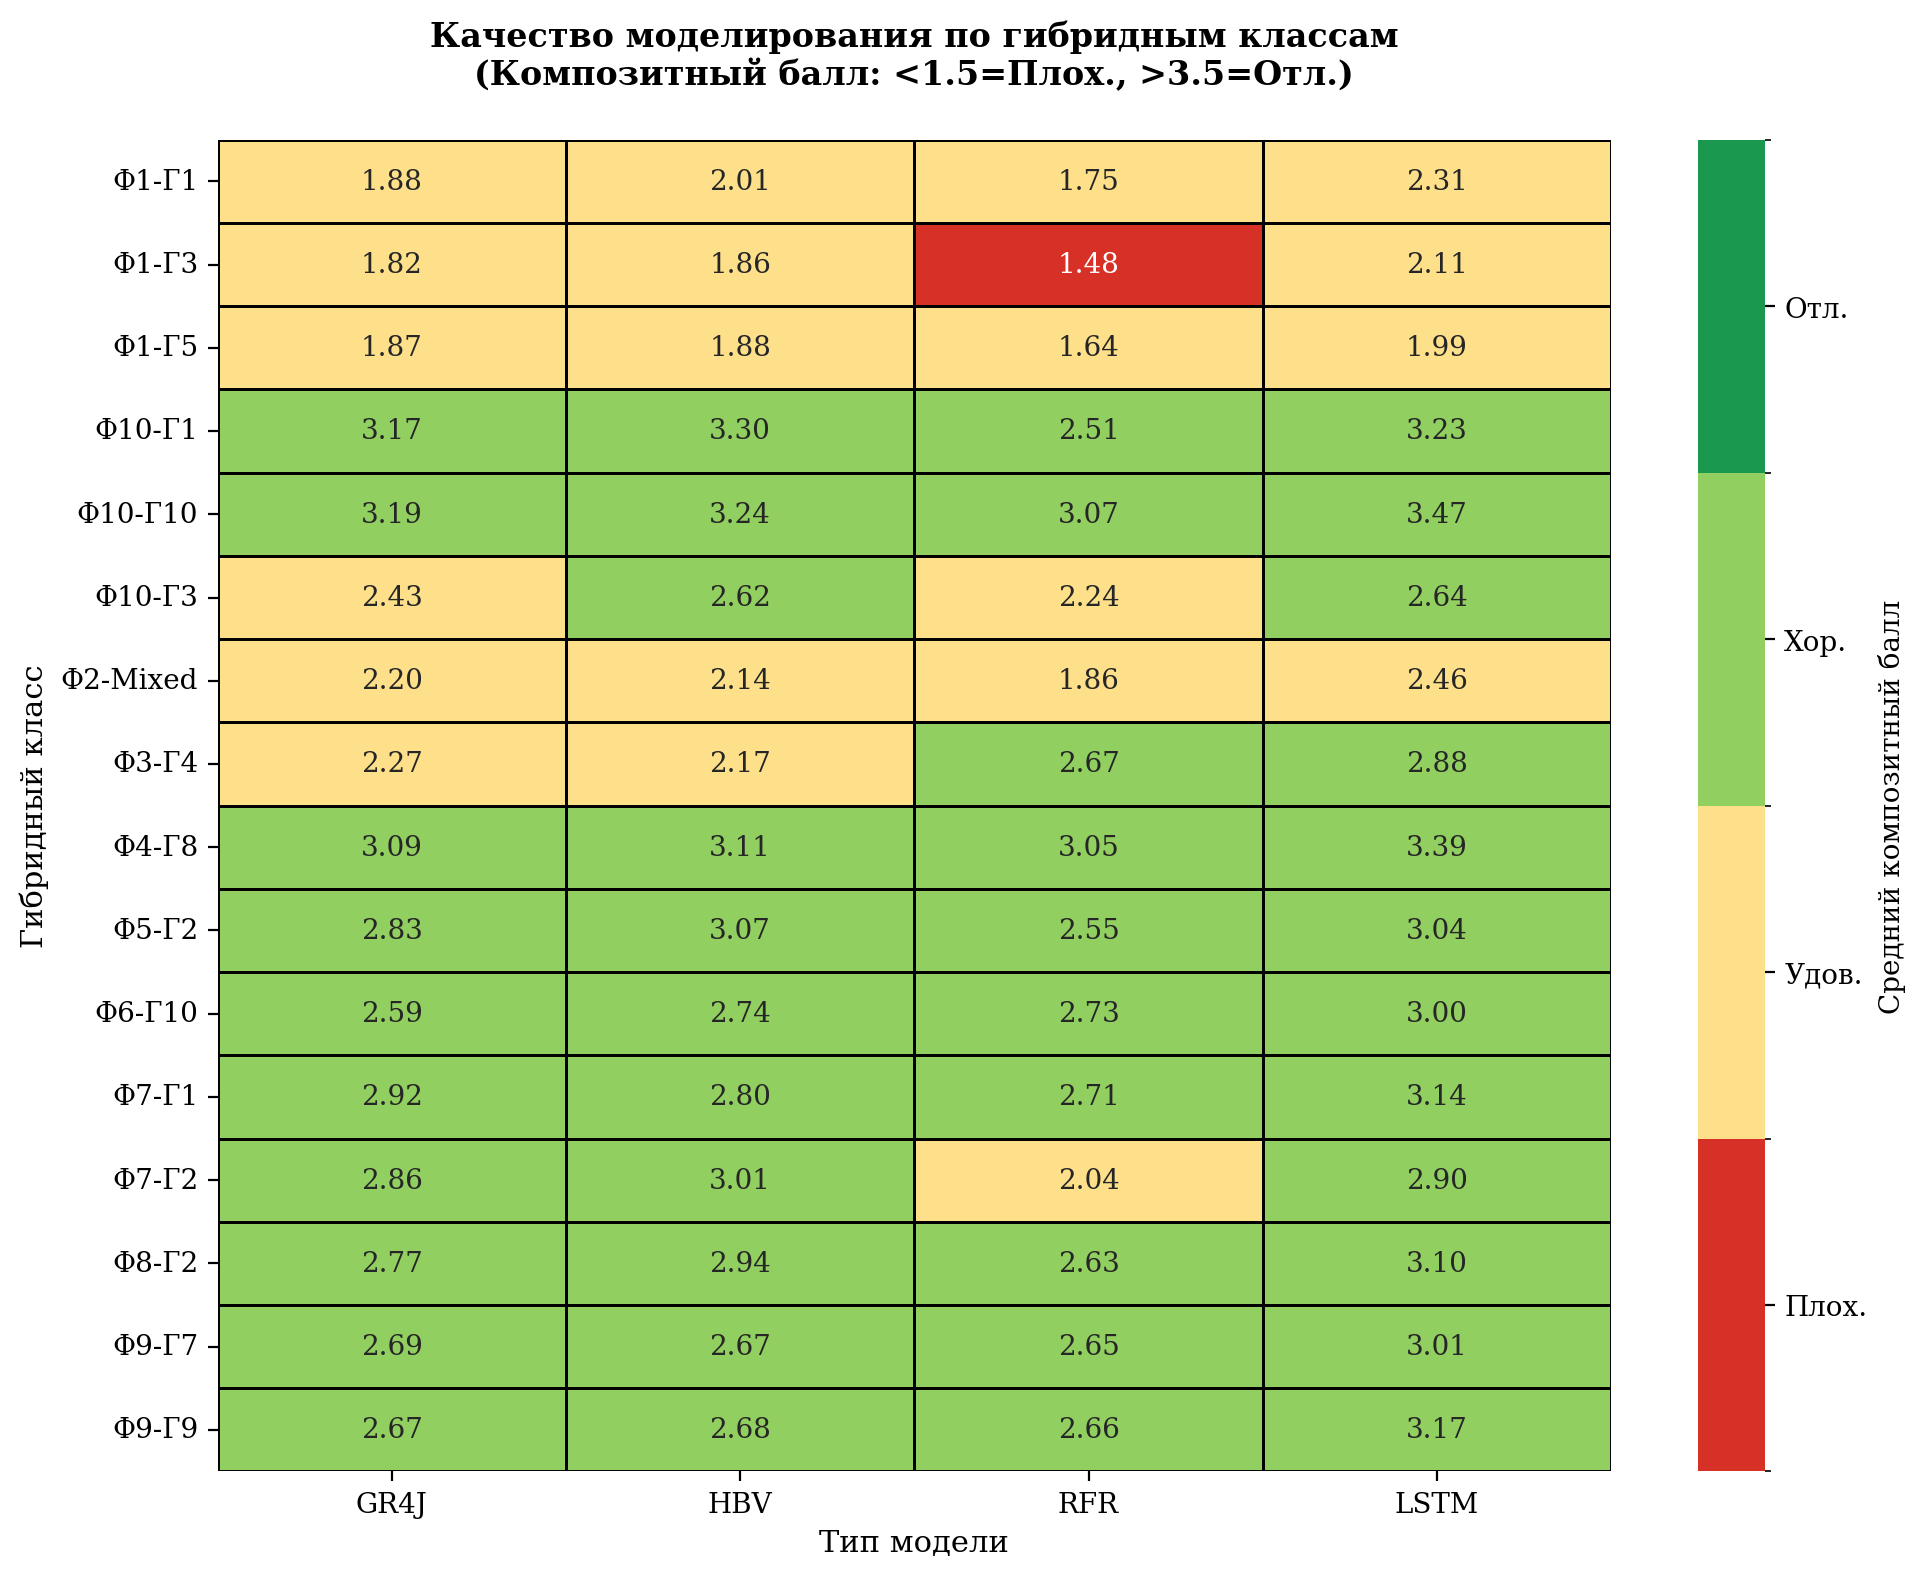

2025-12-10 18:55:54 | INFO     | PhDLogger | chapter_two | ℹ️  Cluster performance heatmap saved: ../res/chapter_two/cluster_performance_heatmap.png


In [35]:
# ============================================================================
# VISUALIZATION 1: Heatmap of Cluster Performance Matrix
# ============================================================================

import matplotlib.colors as mcolors
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

# Define discrete colormap for heatmap
heatmap_colors = ["#d73027", "#fee08b", "#91cf60", "#1a9850"]
heatmap_boundaries = [1.0, 1.5, 2.5, 3.5, 4.0]
heatmap_cmap = mcolors.ListedColormap(heatmap_colors)
heatmap_norm = mcolors.BoundaryNorm(heatmap_boundaries, len(heatmap_colors))

# Create heatmap with annotated values
sns.heatmap(
    summary_matrix,
    annot=True,
    fmt=".2f",
    cmap=heatmap_cmap,
    norm=heatmap_norm,
    cbar_kws={
        "label": "Средний композитный балл",
        "ticks": [1.25, 2.0, 3.0, 3.75],
        "format": lambda x, pos: ["Плох.", "Удов.", "Хор.", "Отл."][
            0 if x < 1.5 else 1 if x < 2.5 else 2 if x < 3.5 else 3
        ],
    },
    ax=ax,
    linewidths=0.5,
    linecolor="black",
)

ax.set_title(
    "Качество моделирования по гибридным классам\n(Композитный балл: <1.5=Плох., >3.5=Отл.)",
    fontsize=12,
    weight="bold",
    pad=20,
)
ax.set_xlabel("Тип модели", fontsize=11)
ax.set_ylabel("Гибридный класс", fontsize=11)
ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
output_path = "../res/chapter_two/cluster_performance_heatmap.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

log.info(f"Cluster performance heatmap saved: {output_path}")


In [31]:
# ============================================================================
# STEP 5: PREPARE SPATIAL DATA FOR VISUALIZATION
# ============================================================================

import matplotlib.colors as mcolors

from src.plots.hex_maps import hexes_plots_n

# Merge composite scores into spatial dataframe
ws_composite = ws.copy()

# Add best model performance metrics for each model type
for model_type in model_types:
    # Get all score columns for this model
    model_score_cols = [
        col
        for col in composite_df.columns
        if col.startswith(f"Composite_Score_{model_type}_")
    ]

    # Get best score across sources for this model
    best_scores = composite_df[model_score_cols].max(axis=1)
    ws_composite[f"Best_{model_type}_Score"] = best_scores.loc[ws_composite.index].values

# Add overall best performance
ws_composite["Best_Overall_Score"] = (
    composite_df["Composite_Score"].loc[ws_composite.index].values
)
ws_composite["Best_Overall_Grade"] = (
    composite_df["Overall_Grade"].loc[ws_composite.index].values
)
ws_composite["Best_Model_Type"] = (
    composite_df["Best_Model_Type"].loc[ws_composite.index].values
)

# Convert categorical grades to numeric for plotting
grade_to_numeric = {"Плох.": 1, "Удов.": 2, "Хор.": 3, "Отл.": 4}
for model_type in model_types:
    score_col = f"Best_{model_type}_Score"
    ws_composite[f"{score_col}_Numeric"] = ws_composite[score_col]

# VALIDATE: Check for missing values
log.info("Validating spatial dataframe:")
for model_type in model_types:
    col = f"Best_{model_type}_Score"
    missing = ws_composite[col].isna().sum()
    log.info(f"  {col}: {missing} missing values")

# VALIDATE: Check CRS
assert ws_composite.crs is not None, "Watershed CRS undefined"
log.info(f"✓ Spatial dataframe validated: CRS={ws_composite.crs}")

print("\n" + "=" * 80)
print("SPATIAL DATA PREPARATION COMPLETE")
print("=" * 80)
print(f"Total watersheds: {len(ws_composite)}")
print(f"Columns added: {len([col for col in ws_composite.columns if 'Best_' in col])}")
print("\nGrade Distribution (Overall):")
for grade in ["Отл.", "Хор.", "Удов.", "Плох."]:
    count = (ws_composite["Best_Overall_Grade"] == grade).sum()
    pct = (count / len(ws_composite)) * 100
    print(f"  {grade:12s}: {count:3d} ({pct:5.1f}%)")


2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️  Validating spatial dataframe:
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_GR4J_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_HBV_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_RFR_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_LSTM_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️  ✓ Spatial dataframe validated: CRS=EPSG:4326
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_GR4J_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_HBV_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_RFR_Score: 0 missing values
2025-12-10 18:54:19 | INFO     | PhDLogger | chapter_two | ℹ️    Best_LSTM_Score: 0 missing values
2025-12-10 


SPATIAL DATA PREPARATION COMPLETE
Total watersheds: 996
Columns added: 11

Grade Distribution (Overall):
  Отл.        : 374 ( 37.6%)
  Хор.        : 373 ( 37.4%)
  Удов.       : 230 ( 23.1%)
  Плох.       :  19 (  1.9%)


2025-12-10 18:58:29 | INFO     | PhDLogger | chapter_two | ℹ️  Generating 2x2 hex-bin map grid...


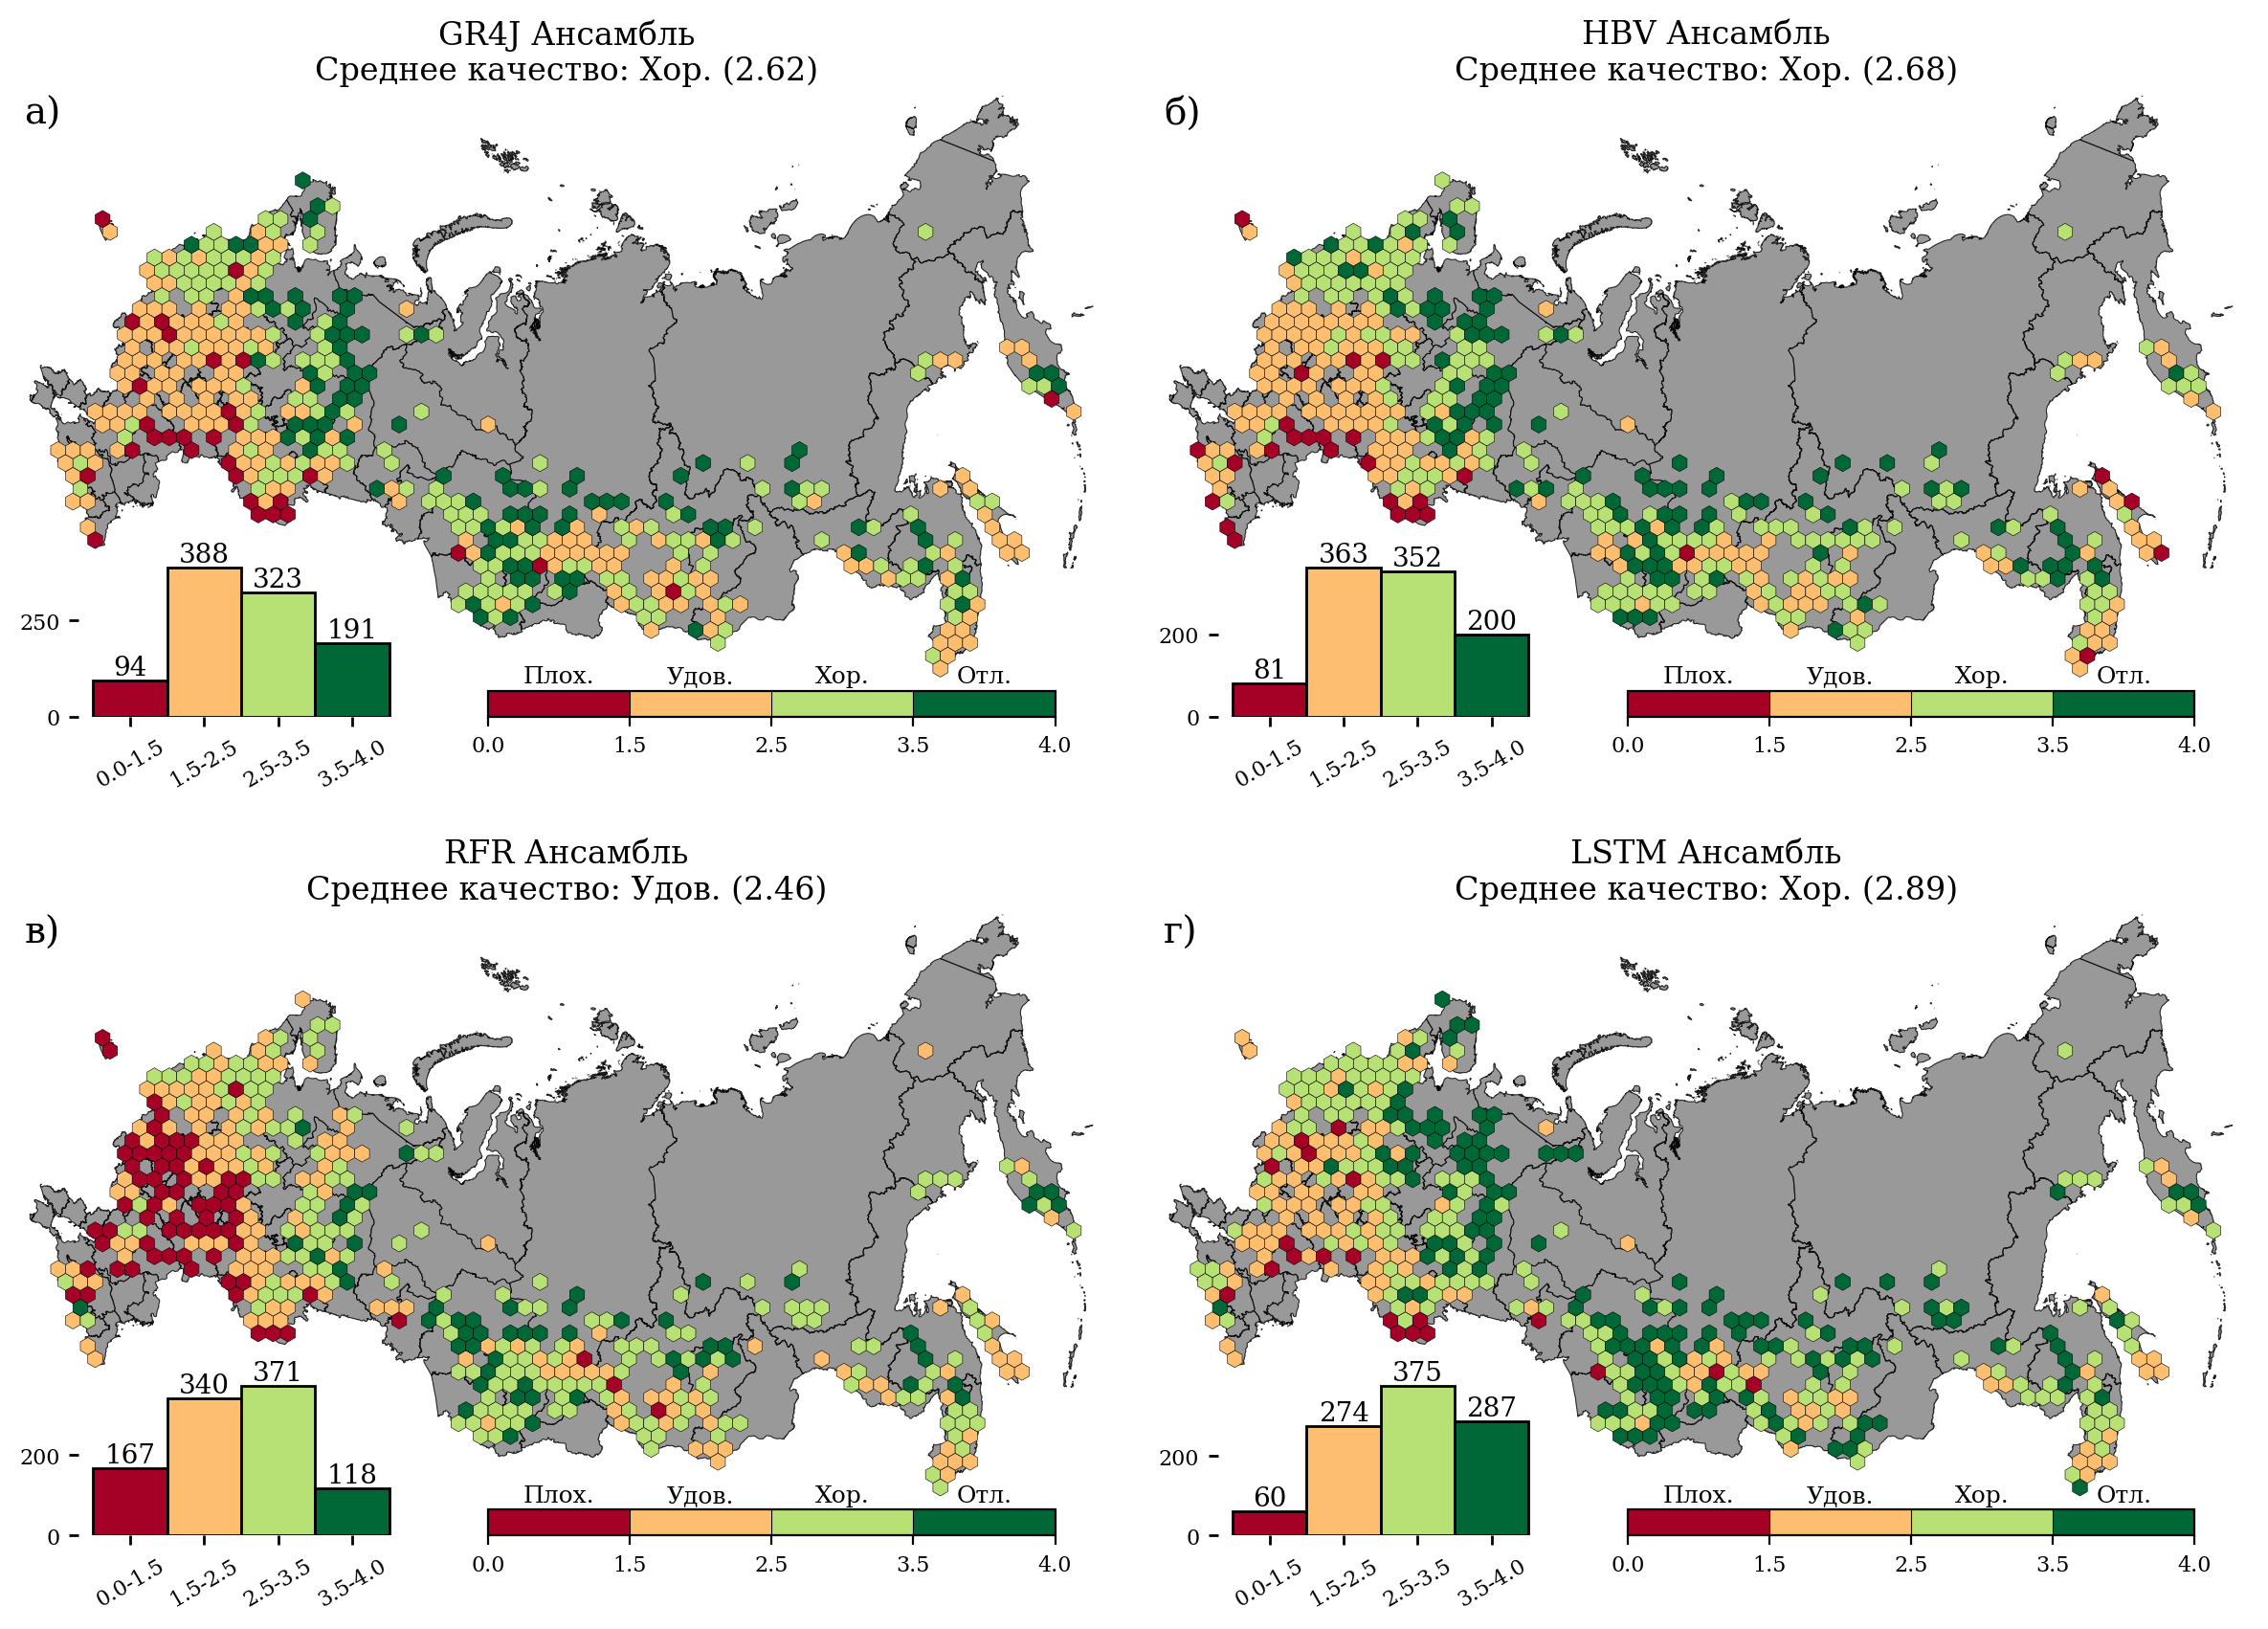

2025-12-10 18:58:38 | INFO     | PhDLogger | chapter_two | ℹ️  ✓ Composite quality hex maps saved: ../res/chapter_two/composite_quality_hex_maps_2x2.png
2025-12-10 18:58:38 | INFO     | PhDLogger | chapter_two | ℹ️    Hex radius: 66.0 km
2025-12-10 18:58:38 | INFO     | PhDLogger | chapter_two | ℹ️    Coverage statistics: 4 metrics processed


In [38]:
# ============================================================================
# VISUALIZATION 2: 2x2 Hex-Bin Grid - Composite Quality by Model Type
# ============================================================================

# Define discrete colormap (matches Chapter 2 style)
composite_colors = ["#d73027", "#fee08b", "#91cf60", "#1a9850"]  # Плох. -> Отл.
composite_boundaries = [0.0, 1.5, 2.5, 3.5, 4.0]
composite_labels = ["Плох.", "Удов.", "Хор.", "Отл."]

composite_cmap = mcolors.ListedColormap(composite_colors)
composite_norm = mcolors.BoundaryNorm(composite_boundaries, len(composite_colors))

# Define metric columns for plotting
metric_cols = [
    "Best_GR4J_Score",
    "Best_HBV_Score",
    "Best_RFR_Score",
    "Best_LSTM_Score",
]

# Calculate mean quality grade for each model type (for titles)
mean_scores = [ws_composite[col].mean() for col in metric_cols]


# Map numeric scores back to grades for display
def score_to_grade(score):
    if score < 1.5:
        return "Плох."
    elif score < 2.5:
        return "Удов."
    elif score < 3.5:
        return "Хор."
    else:
        return "Отл."


mean_grades = [score_to_grade(score) for score in mean_scores]

# Create titles
title_texts = [
    f"GR4J Ансамбль\nСреднее качество: {mean_grades[0]} ({mean_scores[0]:.2f})",
    f"HBV Ансамбль\nСреднее качество: {mean_grades[1]} ({mean_scores[1]:.2f})",
    f"RFR Ансамбль\nСреднее качество: {mean_grades[2]} ({mean_scores[2]:.2f})",
    f"LSTM Ансамбль\nСреднее качество: {mean_grades[3]} ({mean_scores[3]:.2f})",
]

log.info("Generating 2x2 hex-bin map grid...")

# Generate hex-bin maps
fig, metric_hexes, r_km, coverage_stats = hexes_plots_n(
    watersheds=ws_composite,
    basemap_data=basemap_data,
    metric_cols=metric_cols,
    label_list=["а)", "б)", "в)", "г)"],
    nrows=2,
    ncols=2,
    target_ws_per_hex=6.0,
    quantile=0.5,
    min_r_km=40.0,
    max_r_km=120.0,
    agg="median",
    area_weighted=False,
    min_overlap_share=0.1,
    list_of_limits=composite_boundaries,
    figsize=(15, 10),
    cmap_lims=(0.5, 4.5),
    basemap_alpha=0.8,
    annotate_counts=False,
    with_histogram=True,
    title_text=title_texts,
    cb_label=composite_labels,
)

output_path = "../res/chapter_two/composite_quality_hex_maps_2x2.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

log.info(f"✓ Composite quality hex maps saved: {output_path}")
log.info(f"  Hex radius: {r_km:.1f} km")
log.info(f"  Coverage statistics: {len(coverage_stats)} metrics processed")


2025-12-10 18:59:35 | INFO     | PhDLogger | chapter_two | ℹ️  Generating overall best performance map...


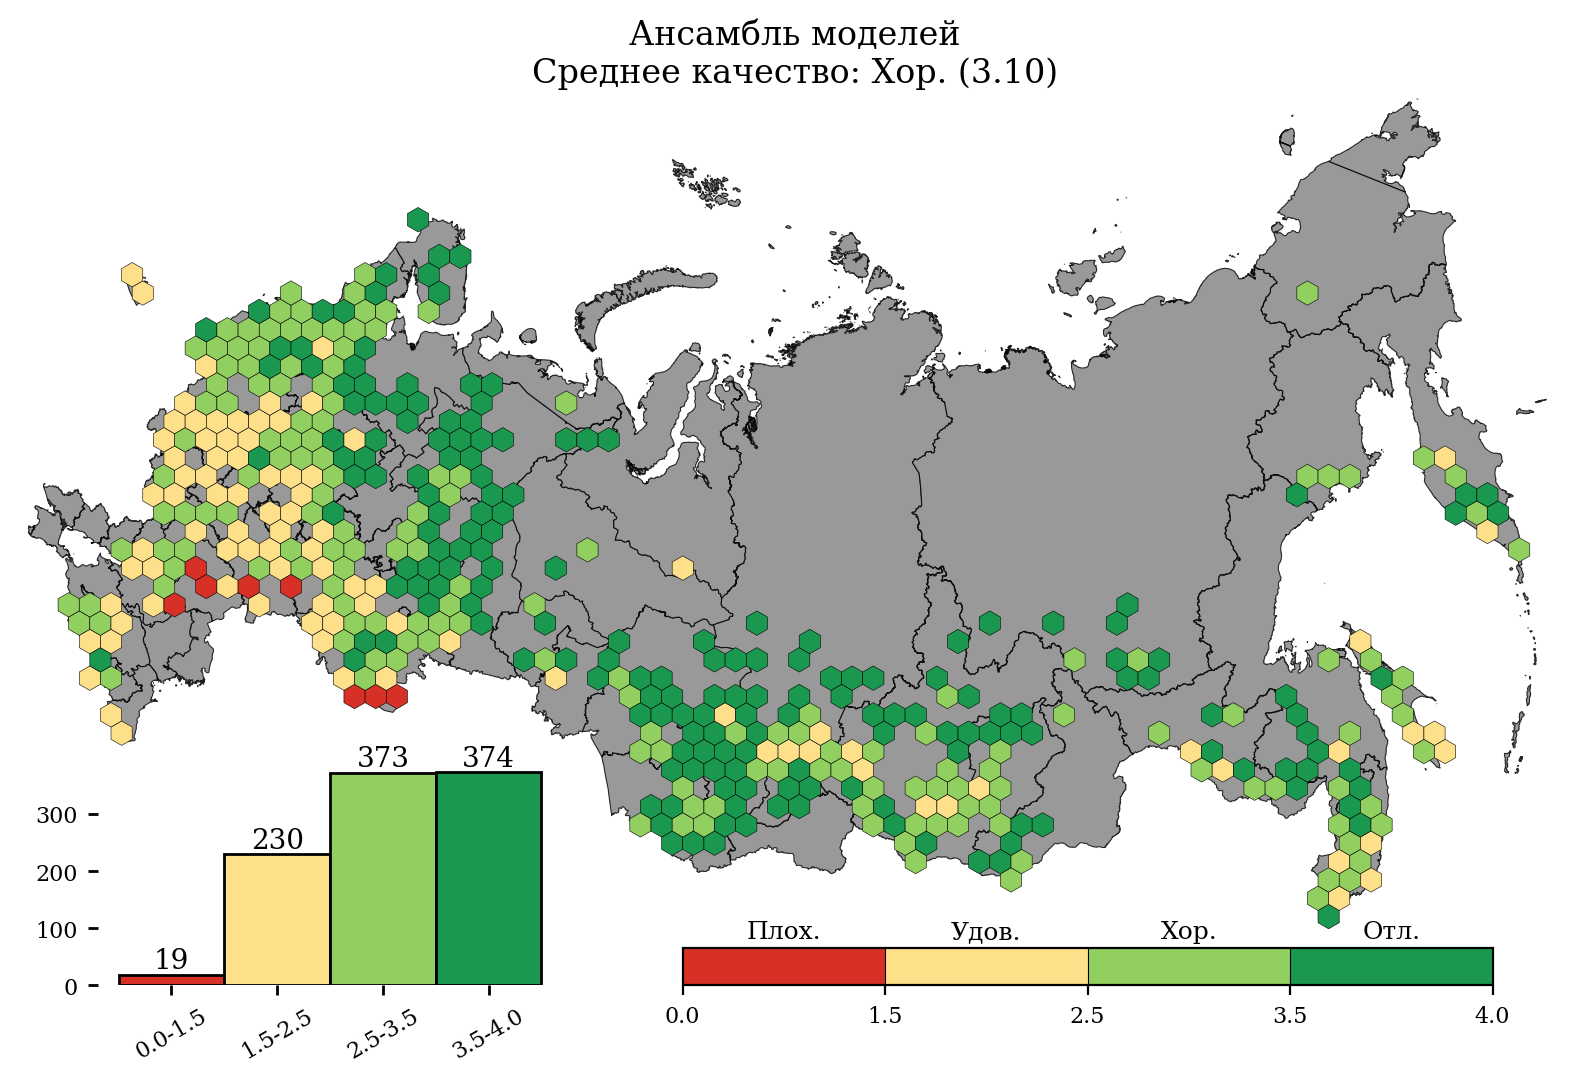

2025-12-10 18:59:37 | INFO     | PhDLogger | chapter_two | ℹ️  ✓ Overall best performance map saved: ../res/chapter_two/best_overall_composite_quality_map.png


In [39]:
# ============================================================================
# VISUALIZATION 3: Single Map - Best Overall Model Performance
# ============================================================================

# Convert overall grade to numeric
ws_composite["Best_Overall_Score_Numeric"] = ws_composite["Best_Overall_Grade"].map(
    grade_to_numeric
)

# Calculate overall statistics
overall_mean = ws_composite["Best_Overall_Score"].mean()
overall_grade = score_to_grade(overall_mean)

log.info("Generating overall best performance map...")

# Generate single hex-bin map
fig, metric_hexes, r_km, coverage_stats = hexes_plots_n(
    watersheds=ws_composite,
    basemap_data=basemap_data,
    metric_cols=["Best_Overall_Score"],
    label_list=[""],
    nrows=1,
    ncols=1,
    target_ws_per_hex=6.0,
    quantile=0.5,
    min_r_km=40.0,
    max_r_km=120.0,
    agg="median",
    area_weighted=False,
    min_overlap_share=0.1,
    rus_extent=(50, 140, 32, 90),
    list_of_limits=composite_boundaries,
    cmap_lims=(0.5, 4.5),
    cmap_name=composite_cmap,
    figsize=(10, 8),
    basemap_alpha=0.8,
    annotate_counts=False,
    with_histogram=True,
    title_text=[
        f"Ансамбль моделей\nСреднее качество: {overall_grade} ({overall_mean:.2f})"
    ],
    cb_label=composite_labels,
)

output_path = "../res/chapter_two/best_overall_composite_quality_map.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

log.info(f"✓ Overall best performance map saved: {output_path}")
